# Compare models

In [19]:
import pickle 
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
from epiweeks import Week
import properscoring as ps
from datetime import datetime
from datetime import datetime
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse

In [40]:
PATH_LSTM = '../predictions/lstm'
PATH_PGBM = '../predictions/pgbm'

## Loading list of cities

In [41]:
df = pd.read_csv('selected_cities.csv', index_col = 'Unnamed: 0')

df.head()

,geocode,state,sum_cases,POP22,inc,n_last_ep,year_first_ep,year_last_ep_before_2023,region,region_codes,start_train_chik,end_train_chik
0,2211001,PI,2325,868523,267.695847,4,2015,2022,ne,1,2014-10-01,2022-11-01
1,2913606,BA,1858,197163,942.367483,2,2015,2016,ne,1,2014-10-01,2016-11-01
2,2914802,BA,1846,185500,995.148248,2,2016,2022,ne,1,2015-10-01,2022-11-01
3,2111300,MA,1788,1061374,168.460882,2,2016,2022,ne,1,2015-10-01,2022-11-01
4,2925303,BA,1687,158736,1062.770890,2,2016,2017,ne,1,2015-10-01,2017-11-01


In [104]:
city = 2802106
state = 'SE'
ini_evaluate = '2022-11-06'
end_evaluate = '2023-10-22'

## Functions
### Skill score

In [0]:
def skill_score_mse(forecast, reference, target):
    '''
    Compute the skill score using the RMSE 
    '''
    
    rmse_f = mse(target, forecast, squared = False )
    
    rmse_r = mse(target, reference, squared = False)
    
    return 1 - (rmse_f/rmse_r)


### CRPS

In [67]:
def nearest_date_index(items, d):
    """
    Returns the index of the item in items which is nearest to the datetime d.
    """
    if isinstance(items[0], pd.Timestamp):
        items = [date.date() for date in items]
    time_diff = np.abs([date - d for date in items])
    return time_diff.argmin(0)

def compute_crps(file,  ini_evaluate = '2022-11-06',
                    end_evaluate = '2023-10-22'): 
    '''
    Function to compute the crps of the ensemble output of the DL models 
    between the two dates.
    '''
    
    with open(file, 'rb') as f:
        data = pickle.load(f)
    # df.iloc[df.index.get_loc(datetime.datetime(2016,2,2),method='nearest')]
    # Since the exact date may not be on the data, we need to find the nearest dates to the ones we want to evaluate
    ini_index= nearest_date_index(data['indice'], datetime.strptime(ini_evaluate, '%Y-%m-%d').date()) - 55
    end_index = nearest_date_index(data['indice'], datetime.strptime(end_evaluate, '%Y-%m-%d').date()) - 55
    print (f"requested dates: {ini_evaluate} - {end_evaluate}, found dates: {data['indice'][ini_index+55]} - {data['indice'][end_index+55]}")
    # ini_index = data['indice'].index(datetime.strptime(ini_evaluate, '%Y-%m-%d').date()) - 55
    # end_index = data['indice'].index(datetime.strptime(end_evaluate, '%Y-%m-%d').date()) - 55

    ensemble = data['factor']*data['ensemble'][ini_index:end_index,-1, ]
    obs = data['factor']*data['target'][ini_index:end_index,-1]

    return ps.crps_ensemble(obs, ensemble).mean()

### CRPS for PGBM models

In [79]:

def compute_crps_pgbm(file,  ini_evaluate = '2022-11-06',
                    end_evaluate = '2023-10-22'): 
    '''
    Function to compute the crps of the ensemble output of the DL models 
    '''
    
    with open(file, 'rb') as f:
        data = pickle.load(f)

    ini_index= nearest_date_index(data['dates'], datetime.strptime(ini_evaluate, '%Y-%m-%d').date())
    end_index = nearest_date_index(data['dates'], datetime.strptime(end_evaluate, '%Y-%m-%d').date())
    print (f"requested dates: {ini_evaluate} - {end_evaluate}, found dates: {data['dates'][ini_index]} - {data['dates'][end_index]}")    
    # ini_index = data['dates'].index(datetime.strptime(ini_evaluate, '%Y-%m-%d').date())
    # end_index = data['dates'].index(datetime.strptime(end_evaluate, '%Y-%m-%d').date())

    ensemble = data['ensemble'][ini_index:end_index]
    obs = data['target'].values[4+ini_index:4+end_index]

    return ps.crps_ensemble(obs, ensemble).mean()


def skill(baseline_score, forecast_score):
    '''
    This function is used with the compute_crps to compute the skill using the crps metric 
    '''
    return (baseline_score - forecast_score) / baseline_score


### Get predictions

In [80]:
def get_preds(path = f'../../predictions/lstm/lstm_2211001_chik_predictions_msle.pkl', label = 'dengue_model', cor_idx= 55):
    '''
    Get the prediction from the lstm models and transform it in a dataframe. 
    '''
    with open(path, 'rb') as f:
        data = pickle.load(f)

    df = pd.DataFrame()
    
    df['date'] = data['indice'][55:]
    
    df[f'target_{label}'] = data['target'][:,-1]*data['factor']
    
    df[f'lower_{label}'] = data['lb'].iloc[:,-1]*data['factor']
    
    df[f'preds_{label}'] = data['pred'].iloc[:,-1]*data['factor']
    
    df[f'upper_{label}'] = data['ub'].iloc[:,-1]*data['factor']
    
    df.set_index('date',inplace = True)
    
    df.index = pd.to_datetime(df.index)
    
    return df


def get_preds_pgbm(path = f'../../predictions/pgbm/pgbm_2211001_chik_cross_predictions.pkl', label = 'dengue_model', cor_idx= 55):
    
    with open(path, 'rb') as f:
        data = pickle.load(f)

    df = pd.DataFrame()
    
    df['date'] = data['dates']
    
    df[f'target_{label}'] = data['target'].values[4:]
    
    df[f'lower_{label}'] = data['preds25']
    
    df[f'preds_{label}'] = data['preds']
    
    df[f'upper_{label}'] = data['preds975']
    
    df.set_index('date',inplace = True)
    
    df.index = pd.to_datetime(df.index)
    
    return df


### Get data

In [81]:
def get_chik_data(city, ini_date = '2022-11-01', end_date = '2023-11-01'):
    '''
    Crate a single dataframe with all the lstm chik predictions: 
    * using the dengue model;
    * using the transf model; 
    * using the chik model. 
    '''
    
    d1 = get_preds(f'{PATH_LSTM}/lstm_{city}_chik_dengue_pred.pkl', label = 'dengue_model')
    
    d2 = get_preds(f'{PATH_LSTM}/lstm_{city}_chik_transf_pred.pkl', label = 'transf_model')

    d3 = get_preds(f'{PATH_LSTM}/lstm_{city}_chik_pred.pkl', label = 'chik_model')
    
    d = d1.merge(d2, left_index=True, right_index=True).merge(d3, 
    left_index=True, right_index=True)

    d['target'] = d['target_dengue_model']

    d = d.drop(['target_dengue_model', 'target_transf_model',
           'target_chik_model'], axis = 1)
    
    d = d.loc[ (d.index >= ini_date) & (d.index <= end_date )]

    return d


def get_chik_data_pgbm(city, ini_date = '2022-11-01', end_date = '2023-11-01'):
    '''
    Crate a single dataframe with the transf and the pgbm chik predictions: 
    * using the dengue model (pgbm);
    * using the transf model; 
    * using the chik model (pgbm). 
    '''
    
    d1 = get_preds_pgbm(f'{PATH_PGBM}/pgbm_{city}_chik_cross_pred.pkl', label = 'dengue_model')
    
    d2 = get_preds(f'{PATH_LSTM}/lstm_{city}_chik_transf_pred.pkl', label = 'transf_model')

    d3 = get_preds_pgbm(f'{PATH_PGBM}/pgbm_{city}_chik_pred.pkl', label = 'chik_model')
    
    d = d1.merge(d2, left_index=True, right_index=True).merge(d3, 
    left_index=True, right_index=True)

    d['target'] = d['target_transf_model']

    d = d.drop(['target_dengue_model', 'target_transf_model',
           'target_chik_model'], axis = 1)
    
    d = d.loc[ (d.index >= ini_date) & (d.index <= end_date )]

    return d


### Plot Comparisons

In [118]:
def plot_comp(city, ini_evaluate = '2022-11-01', end_evaluate = '2023-11-01', model = 'DL', plot = True): 
    '''
    Function to compare the predictions in a given interval and compute the ss. 
    If the model is DL it's used the lstm model and is computed the skill score using crps 
    '''
    if model =='DL':
        df = get_chik_data(city, ini_date = ini_evaluate,
                             end_date = end_evaluate)
    if model == 'PGBM': 
        df = get_chik_data_pgbm(city, ini_date = ini_evaluate,
                             end_date = end_evaluate)
    
    plt.plot(df.index, df.target , color = 'black', label = 'Data', linewidth=2)

    plt.plot(df.index, df.preds_dengue_model, label = f'{model} - Dengue', color = 'tab:blue', ls = 'dashed', linewidth=2)

    plt.fill_between(df.index, df.lower_dengue_model,
                    df.upper_dengue_model,  color = 'tab:blue',
                    alpha = 0.2)


    plt.plot(df.index, df.preds_transf_model, label = f'TL', linewidth=2,
                        color = 'tab:red', ls = 'dashdot')

    plt.fill_between(df.index, df.lower_transf_model, 
                    df.upper_transf_model,
                        color = 'tab:red', alpha = 0.2)

    plt.xlabel('Date')

    plt.ylabel('New cases')

    plt.plot(df.index, df.preds_chik_model, label = f'{model} - Chik',color = 'tab:orange', ls = 'dotted', linewidth=2)

    plt.fill_between(df.index, df.lower_chik_model,
                   df.upper_chik_model, alpha = 0.2, color = 'tab:orange')


    plt.grid()

    plt.legend()

    plt.title(f'Chikungunya forecasts at {city} ({model})')
    
    
    for tick in plt.gca().get_xticklabels():
        tick.set_rotation(20)
    plt.savefig(f'../figures/forecast_{city}_{model}.png', dpi = 300, bbox_inches = 'tight') 
    if plot:
        plt.show()
    else:
        plt.close()
    print('Skill score using RMSE')
        
    print('TL vs DL - dengue:', skill_score_mse(forecast = df.preds_transf_model, 
                                            reference = df.preds_dengue_model, 
                                            target = df.target))
    
    print('TL vs DL - chik:', skill_score_mse(forecast = df.preds_transf_model, 
                                            reference = df.preds_chik_model, 
                                            target = df.target))

    if model == 'DL':
        
        print('Skill score using CRPS')
        
        crps1 = compute_crps(f'{PATH_LSTM}/lstm_{city}_chik_dengue_pred.pkl',
                             ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)
    
        crps2 = compute_crps(f'{PATH_LSTM}/lstm_{city}_chik_transf_pred.pkl',
                            ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)

        crps3 = compute_crps(f'{PATH_LSTM}/lstm_{city}_chik_pred.pkl',
                            ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)

        print('TL vs DL - dengue:', skill(baseline_score = crps1, 
                                          forecast_score = crps2))

        print('TL vs DL - chik:', skill(baseline_score = crps3, 
                                          forecast_score = crps2))
    if model == 'PGBM':
        
        print('Skill score using CRPS')
        
        crps1 = compute_crps_pgbm(f'{PATH_PGBM}/pgbm_{city}_chik_cross_pred.pkl',
                             ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)
    
        crps2 = compute_crps(f'{PATH_LSTM}/lstm_{city}_chik_transf_pred.pkl',
                            ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)

        crps3 = compute_crps_pgbm(f'{PATH_PGBM}/pgbm_{city}_chik_pred.pkl',
                            ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)

        print('TL vs PGBM - dengue:', skill(baseline_score = crps1, 
                                          forecast_score = crps2))

        print('TL vs PGBM - chik:', skill(baseline_score = crps3, 
                                          forecast_score = crps2))

    return
    

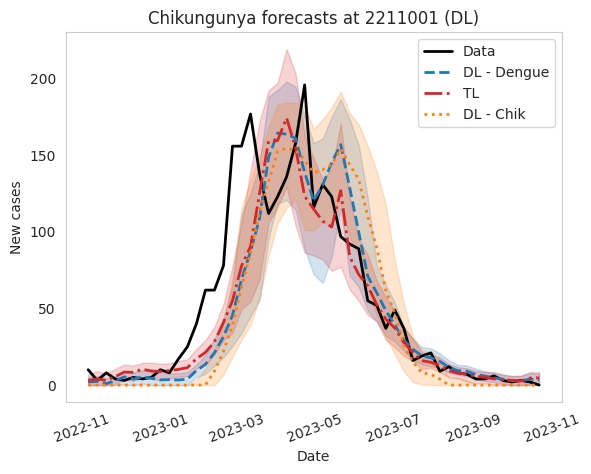

Skill score using RMSE
TL vs DL - dengue: 0.08310631726961659
TL vs DL - chik: 0.1808967906798482
Skill score using CRPS
requested dates: 2022-11-06 - 2023-10-22, found dates: 2022-11-06 00:00:00 - 2023-10-22 00:00:00
requested dates: 2022-11-06 - 2023-10-22, found dates: 2022-11-06 00:00:00 - 2023-10-22 00:00:00
requested dates: 2022-11-06 - 2023-10-22, found dates: 2022-11-06 00:00:00 - 2023-10-22 00:00:00
TL vs DL - dengue: 0.12500624595554394
TL vs DL - chik: 0.3051659783578397


In [119]:
plot_comp(city, ini_evaluate = ini_evaluate, end_evaluate = end_evaluate, model = 'DL')

Skill score using RMSE
TL vs DL - dengue: 0.4391225864254611
TL vs DL - chik: 0.45288922999624937
Skill score using CRPS
requested dates: 2022-11-06 - 2023-10-22, found dates: 2022-11-06 00:00:00 - 2023-10-22 00:00:00
requested dates: 2022-11-06 - 2023-10-22, found dates: 2022-11-06 00:00:00 - 2023-10-22 00:00:00
requested dates: 2022-11-06 - 2023-10-22, found dates: 2022-11-06 00:00:00 - 2023-10-22 00:00:00
TL vs PGBM - dengue: 0.41843775317573706
TL vs PGBM - chik: 0.4276698478241417


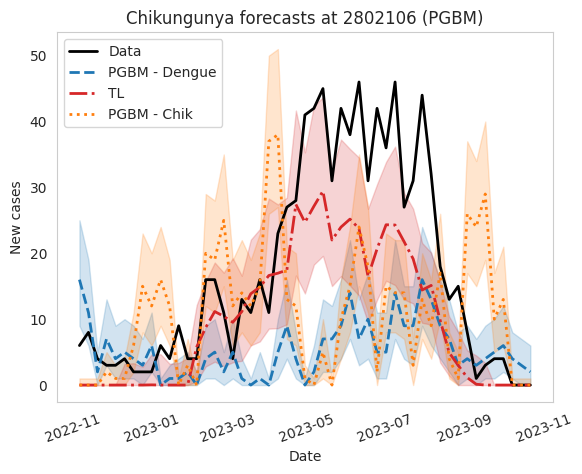

In [107]:
plot_comp(city, ini_evaluate = ini_evaluate, end_evaluate = end_evaluate, model = 'PGBM')

In [108]:
df.head()

,geocode,state,sum_cases,POP22,inc,n_last_ep,year_first_ep,year_last_ep_before_2023,region,region_codes,start_train_chik,end_train_chik
0,2211001,PI,2325,868523,267.695847,4,2015,2022,ne,1,2014-10-01,2022-11-01
1,2913606,BA,1858,197163,942.367483,2,2015,2016,ne,1,2014-10-01,2016-11-01
2,2914802,BA,1846,185500,995.148248,2,2016,2022,ne,1,2015-10-01,2022-11-01
3,2111300,MA,1788,1061374,168.460882,2,2016,2022,ne,1,2015-10-01,2022-11-01
4,2925303,BA,1687,158736,1062.770890,2,2016,2017,ne,1,2015-10-01,2017-11-01


In [112]:
city = 2211001

Skill score using RMSE
TL vs DL - dengue: 0.08310631726961659
TL vs DL - chik: 0.1808967906798482
Skill score using CRPS
requested dates: 2022-11-06 - 2023-10-22, found dates: 2022-11-06 00:00:00 - 2023-10-22 00:00:00
requested dates: 2022-11-06 - 2023-10-22, found dates: 2022-11-06 00:00:00 - 2023-10-22 00:00:00
requested dates: 2022-11-06 - 2023-10-22, found dates: 2022-11-06 00:00:00 - 2023-10-22 00:00:00
TL vs DL - dengue: 0.12500624595554394
TL vs DL - chik: 0.3051659783578397


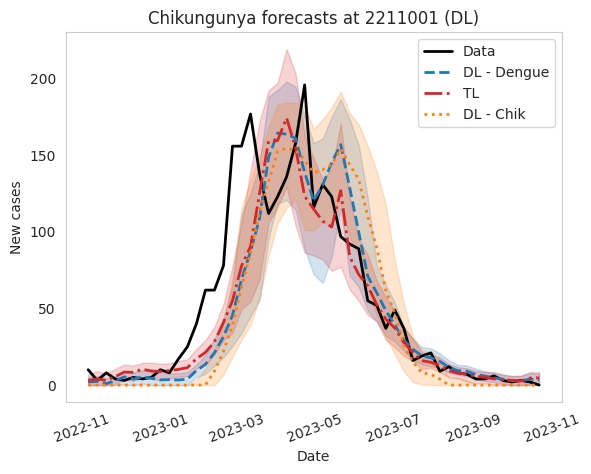

In [113]:
plot_comp(city, ini_evaluate = ini_evaluate, end_evaluate = end_evaluate, model = 'DL')

Skill score using RMSE
TL vs DL - dengue: 0.8617044433322282
TL vs DL - chik: 0.145307743447341
Skill score using CRPS
requested dates: 2022-11-06 - 2023-10-22, found dates: 2022-11-06 00:00:00 - 2023-10-22 00:00:00
requested dates: 2022-11-06 - 2023-10-22, found dates: 2022-11-06 00:00:00 - 2023-10-22 00:00:00
requested dates: 2022-11-06 - 2023-10-22, found dates: 2022-11-06 00:00:00 - 2023-10-22 00:00:00
TL vs PGBM - dengue: 0.7939696793549831
TL vs PGBM - chik: 0.6143087495516071


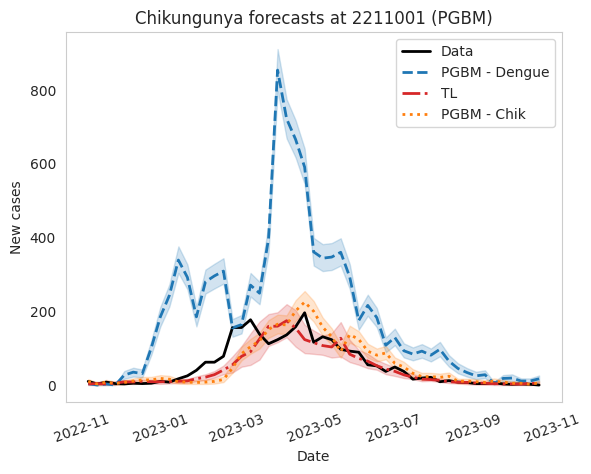

In [114]:
plot_comp(city, ini_evaluate = ini_evaluate, end_evaluate = end_evaluate, model = 'PGBM')

## New qq plot (only DL models by now):

In [115]:
def gen_data_to_qq(city, ini_evaluate,end_evaluate):
    
    df_end = pd.DataFrame()
    
    df = get_chik_data(city, ini_date = ini_evaluate,
                             end_date = end_evaluate)


    df_end['dates'] = df.index
    df_end['dates'] = pd.to_datetime(df_end['dates'])
    df_end['week'] = [Week.fromdate(i).weektuple()[1] for i in df_end['dates']] 
    df_end['target_chik'] = df['target'].values
    df_end['preds_dl_dengue'] =  df['preds_dengue_model'].values
    
    df_end['preds_tl'] =  df['preds_chik_model'].values

    df_end['preds_dl_chik'] = df['preds_chik_model'].values
    
    # adicionando os dados de dengue: 
    
    df_dengue = pd.read_csv(f'../data/dengue_{city}_cluster.csv', index_col = 'Unnamed: 0' , usecols = ['Unnamed: 0', f'casos_{city}'])
    
    
    df_dengue.index = pd.to_datetime(df_dengue.index)
    
    df_dengue['week'] = [Week.fromdate(i).weektuple()[1] for i in df_dengue.index] 
    
    df_dengue['year'] = [Week.fromdate(i).weektuple()[0] for i in df_dengue.index]
    
    #adicionando data faltando 
    
    v = ( df_dengue.loc['2018-04-01'][f'casos_{city}'] + df_dengue.loc['2018-04-15'][f'casos_{city}'] )/2
    
    f = {f'casos_{city}':v, 'week':15 , 'year':2018}
    
    
    s = pd.DataFrame(f, index=['2018-04-08'])
    
    # df_dengue = df_dengue.append(s)
    df_dengue = pd.concat([df_dengue, s], axis=0)
 
    df_dengue.index = pd.to_datetime(df_dengue.index)
    
    df_dengue = df_dengue.sort_index()
    
    
    for y in np.arange(2010, max(df_end.dates.dt.year)):
        
        df_s = df_dengue.loc[df_dengue.year == y]
        
        try:

            df_end[f'dengue_{y}'] = df_s.loc[ df_s.week.isin(df_end.week)][f'casos_{city}'].values
            
        except:
                        
            print('Erro para o ano:')
            print(y)
    


    
    return df_end

In [116]:
def plot_cross_qq(ax, q_o, q_p, title):
    sns.kdeplot(x = q_o[len(q_p) - len(q_o):], y = q_p, ax =ax, fill = True)
    ax.set_xlabel('observed')
    ax.set_ylabel('predicted')
    
    max_v = max( max(q_p), max(q_o))
    
    ax.set_xlim([0, max_v])
    ax.set_ylim([0, max_v])
    ax.plot([0, 100], [0, 100], 'k')
    
    ax.set_title(f'{title} - p.25: {round(np.percentile(q_p - q_o, 25),2)} - p.50: {round(np.median(q_p - q_o), 2)} - p.75: {round(np.percentile(q_p - q_o, 75), 2)}')
    #P.title(f'Transfer prediction percentiles with {model_name.lower()} for {doenca} at {city_name}')

def gen_qq_plot(city, ini_evaluate, end_evaluate):
    
    df =  gen_data_to_qq(city, ini_evaluate, end_evaluate)
    
    cols = df.columns[ df.columns.str.startswith('dengue')]
    
    obs_preds = df[cols].values

    chik = df['target_chik'].values

    pred_tl = df['preds_tl'].values

    pred_dl_dengue = df['preds_dl_dengue'].values
    
    pred_dl_chik = df['preds_dl_chik'].values

    q_o = ss.percentileofscore(obs_preds, chik)

    q_p_dl_dengue = ss.percentileofscore(obs_preds, pred_dl_dengue)
    
    q_p_dl_chik = ss.percentileofscore(obs_preds, pred_dl_chik)

    q_p_tl = ss.percentileofscore(obs_preds, pred_tl)
    
    fig, ax = plt.subplots(1,3, figsize = (12,4))

    fig.suptitle(f'City - {city}', fontsize=12)
    
    plot_cross_qq(ax[0], q_o, q_p_tl, title = 'TL')

    plot_cross_qq(ax[1], q_o, q_p_dl_dengue, title = 'DL - dengue')
    
    plot_cross_qq(ax[2], q_o, q_p_dl_dengue, title = 'DL - chik')
    
    plt.savefig(f'../figures/qq_plot_{city}.png', dpi = 300, bbox_inches = 'tight')
    
    plt.tight_layout()
    
    plt.show()
    
    return


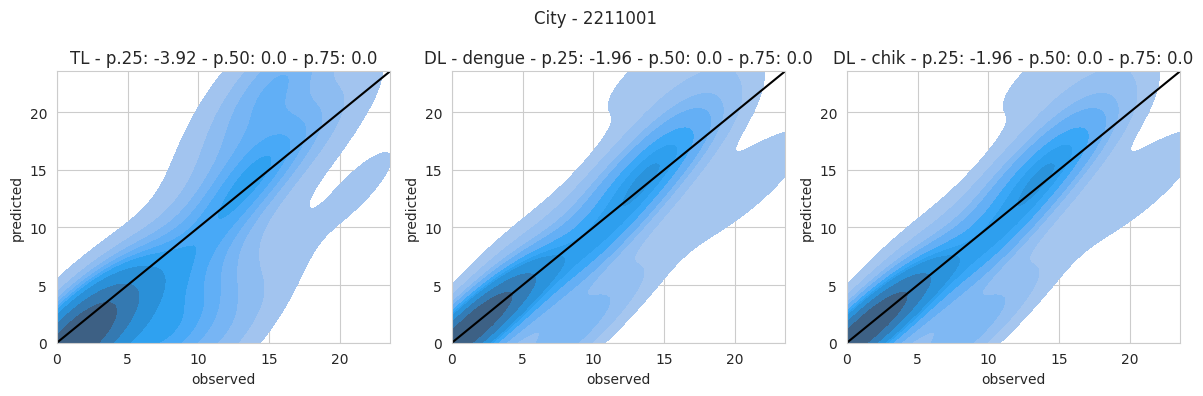

In [117]:
gen_qq_plot(city = city, ini_evaluate = ini_evaluate, end_evaluate = end_evaluate)

In [95]:
from pgbm.sklearn import HistGradientBoostingRegressor, crps_ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import numpy as np
X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
model = HistGradientBoostingRegressor(random_state=0).fit(X_train, y_train)  
yhat_point, yhat_point_std = model.predict(X_test, return_std=True)
yhat_dist = model.sample(yhat_point, yhat_point_std, n_estimates=1000, random_state=0)

In [96]:
yhat_dist.shape

(1000, 2064)

In [97]:
yhat_point.shape

(2064,)

In [98]:
np.percentile(yhat_dist, 0.025, axis=0).shape

(2064,)

In [ ]:
for city, ini_date, end_date_train in zip(
        df.geocode, df.start_train_chik, df.end_train_chik):
    plot_comp(city, ini_evaluate = ini_date, end_evaluate = end_date, model = 'DL', plot = False)
    plot_comp(city, ini_evaluate = ini_date, end_evaluate = end_date, model = 'PGBM', plot = False)